### Table of Contents: <a id="1"></a>
1. [About the dataset](#1)
2. [Importing Data- Modcloth](#3)
3. [EDA & Preprocessing](#4)
    1. [Boxplot of Numerical Variables](#5)
    2. [Handling Outliers](#6)
    3. [Joint Distribution of bra_size vs size](#7)
4. [Data Cleaning & Preprocessing](#8)
    1. [Initial Distribution of Features](#9)
    2. [Step-by-step feature processing](#10)
        1. [Feature Engineering - new feature added](#11)
5. [EDA via Visualizations](#12)
    1. [Distribution of features](#13)
    2. [Categories vs. Fit/Length/Quality](#14)
    3. [Users vs Items bought](#15)
    4. [Height vs Shoe-size](#16)
6. [References](#references)
7. [Assumptions](#assumptions)

<a id="1"></a>
### About the dataset

>This dataset contains self-reported clothing-fit feedback from customers as well as other side information like reviews, ratings, product categories, catalog sizes, customers’ measurements (etc.) from 2 websites:
>1. [Modcloth](http://modcloth.com)
>2. [Renttherunway](http://renttherunway.com)
>
>[[1]](#references) ModCloth sells women’s vintage clothing and accessories, from which the curator of the dataset collected data from three categories: dresses, tops, and bottoms. RentTheRunWay is a unique platform that allows women to rent clothes for various occasions; they collected data from several categories. 
>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Suppressing all warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.rc('figure', figsize = (20, 8))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes.spines', top = False, right = False)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')

<a id="2"></a>
#  [Modcloth](http://modcloth.com) Dataset
<a id="3"></a>
## Importing data using Pandas
Taking a look at the first few lines of the modcloth data's json file. 

Using the pd.read_json() function the json file is brought into a pandas DataFrame, with the *lines* parameter as *True*- because every new object is separated by a new line. 

In [4]:
mc_df = pd.read_json('modcloth_final_data.json', lines=True)
mc_df.head()

,item_id,waist,size,quality,cup size,hips,bra size,category,bust,height,user_name,length,fit,user_id,shoe size,shoe width,review_summary,review_text
0,123373,29.0,7,5.0,d,38.0,34.0,new,36,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN
1,123373,31.0,13,3.0,b,30.0,36.0,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN
2,123373,30.0,7,2.0,b,NaN,32.0,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.0,NaN,NaN,NaN
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN
4,123373,NaN,18,5.0,b,NaN,36.0,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN


<a id="4"></a>
# EDA - Exploratory Data Analysis

We can already make few observations here, by looking at the head of the data:
1. There are missing values across the dataframe, which need to be handled.
2. Cup-size contains multiple preferences- which will need handling, if we wish to define cup sizes as 'category' datatype.
3. Height column needs to be parsed for extracting the height in a numerical quantity, it looks like a string (object) right now.
4. Not so important, but some columns could do with some renaming- for removing spaces.

Firstly, we handle the naming of columns for ease-of-access in pandas.

In [5]:
mc_df.columns

Index(['item_id', 'waist', 'size', 'quality', 'cup size', 'hips', 'bra size',
       'category', 'bust', 'height', 'user_name', 'length', 'fit', 'user_id',
       'shoe size', 'shoe width', 'review_summary', 'review_text'],
      dtype='object')

In [6]:
mc_df.columns = ['bra_size', 'bust', 'category', 'cup_size', 'fit', 'height', 'hips',
       'item_id', 'length', 'quality', 'review_summary', 'review_text',
       'shoe_size', 'shoe_width', 'size', 'user_id', 'user_name', 'waist']

In [7]:
mc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82790 entries, 0 to 82789
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bra_size        82790 non-null  int64  
 1   bust            2882 non-null   float64
 2   category        82790 non-null  int64  
 3   cup_size        82722 non-null  float64
 4   fit             76535 non-null  object 
 5   height          56064 non-null  float64
 6   hips            76772 non-null  float64
 7   item_id         82790 non-null  object 
 8   length          11854 non-null  object 
 9   quality         81683 non-null  object 
 10  review_summary  82790 non-null  object 
 11  review_text     82755 non-null  object 
 12  shoe_size       82790 non-null  object 
 13  shoe_width      82790 non-null  int64  
 14  size            27915 non-null  float64
 15  user_id         18607 non-null  object 
 16  user_name       76065 non-null  object 
 17  waist           76065 non-null 

We can extend our observations on missing data and the datatypes here:
* Out of 18 columns, only 6 columns have complete data.
* Quite a lot of data seems to be missing in bust, shoe width, shoe size and waist.
* We might want to especially look at the items which **have** shoe size and shoe width available- these could possibly be shoes!
* Alot of the columns have strings (object datatype), which needs to be parsed into the category datatype (aids in efficient memory consumption as well). 
* *Waist* column surprisingly has a lot of NULL values- considering most of the data from Modcloth comes from the 3 categories of 'dresses, tops and bottoms'.

### Looking at the percentage of missing values per column

In [8]:
missing_data = pd.DataFrame({'total_missing': mc_df.isnull().sum(), 'perc_missing': (mc_df.isnull().sum()/82790)*100})
missing_data

,total_missing,perc_missing
bra_size,0,0.000000
bust,79908,96.518903
category,0,0.000000
cup_size,68,0.082136
fit,6255,7.555260
height,26726,32.281677
hips,6018,7.268994
item_id,0,0.000000
length,70936,85.681846
quality,1107,1.337118


### Statistical description of numerical variables

In [9]:
mc_df.describe()

,bra_size,bust,category,cup_size,height,hips,shoe_width,size
count,82790.000000,2882.000000,82790.000000,82722.000000,56064.000000,76772.000000,82790.000000,27915.000000
mean,469325.229170,31.319223,12.661602,3.949058,40.358501,35.972125,498849.564718,8.145818
std,213999.803314,5.302849,8.271952,0.992783,5.827166,3.224907,286356.969459,1.336109
min,123373.000000,20.000000,0.000000,1.000000,30.000000,28.000000,6.000000,5.000000
25%,314980.000000,28.000000,8.000000,3.000000,36.000000,34.000000,252897.750000,7.000000
50%,454030.000000,30.000000,12.000000,4.000000,39.000000,36.000000,497913.500000,8.000000
75%,658440.000000,34.000000,15.000000,5.000000,43.000000,38.000000,744745.250000,9.000000
max,807722.000000,50.000000,38.000000,5.000000,60.000000,48.000000,999972.000000,38.000000


Some more important observations here, before we dive into performing the pre-processing tasks onto our data:
* Bra_size, hips might not need to be a float- category dtype?
* Most of the shoe sizes are around 5-9, but the maximum shoe size is 38! (It is surprising as the website uses UK shoe sizing.)
* Size has a minimum of 0 and maximum Size matches the maximum shoe size.

Let's visualize the numerical quantities in our dataset as boxplots, to have a better sense of the outliers.

<a id="5"></a>
## Boxplot of numerical variables

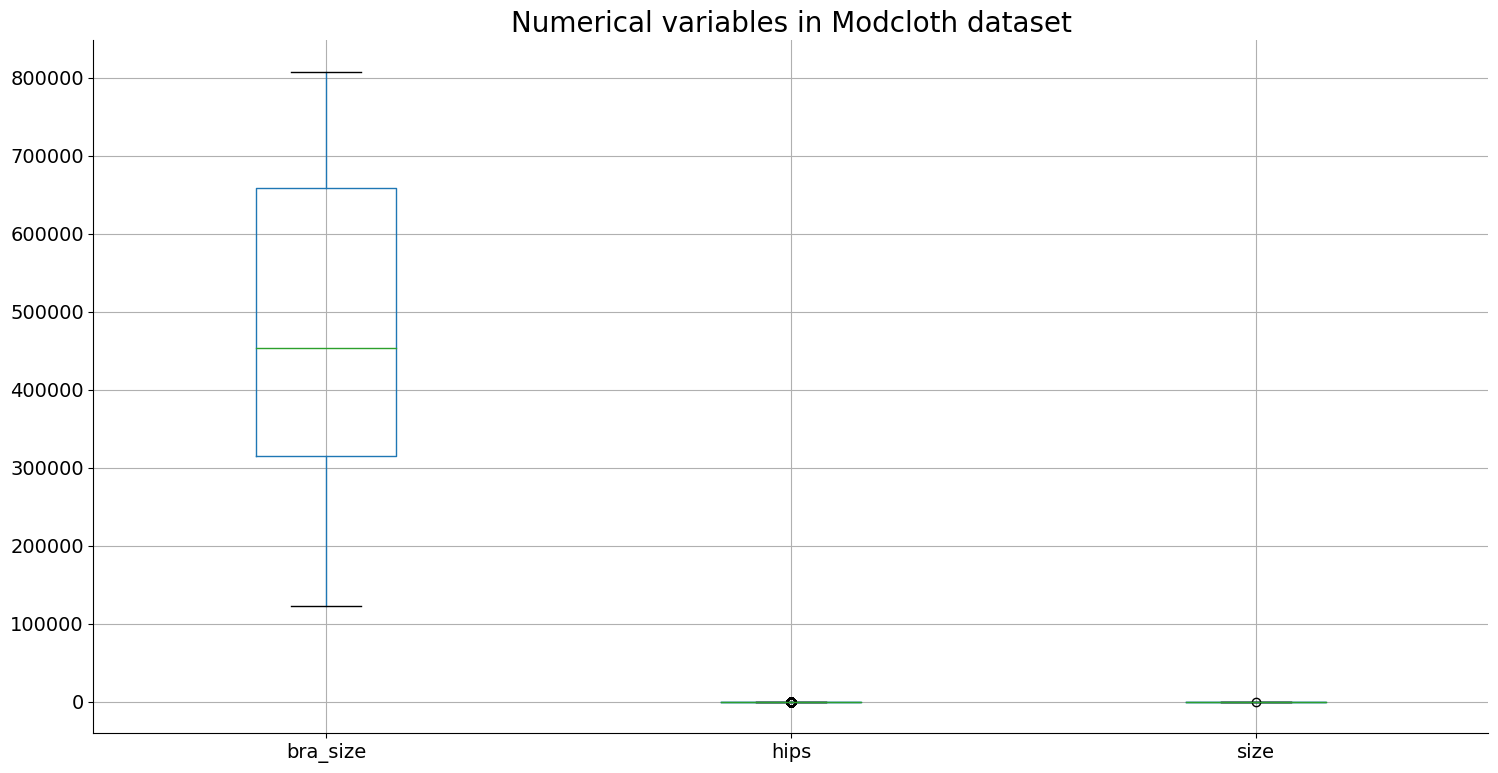

In [10]:
num_cols = ['bra_size','hips','quality','shoe_size','size','waist']
plt.figure(figsize=(18,9))
mc_df[num_cols].boxplot()
plt.title("Numerical variables in Modcloth dataset", fontsize=20)
plt.show()

<a id="6"></a>
## Handling Outliers

* **shoe_size**:
We can clearly see that the single maximum value of shoe size (38) is an outlier and we should ideally remove that row or handle that outlier value. Let's take a look at that entry in our data.

In [11]:
mc_df[mc_df.shoe_size == 38]

,bra_size,bust,category,cup_size,fit,height,hips,item_id,length,quality,review_summary,review_text,shoe_size,shoe_width,size,user_id,user_name,waist


>We can see that the entry seems to be legit, except for the shoe size- it could be wrongly entered by the customer or simple noise. We'll enter this as null value for now.

In [12]:
mc_df.at[37313,'shoe_size'] = None

* **bra_size**:
We can take a look at the top 10 bra-sizes (we can see that boxplot shows 2 values as outliers, as per the IQR- Inter-Quartile Range).

In [13]:
mc_df.sort_values(by=['bra_size'], ascending=False).head(10)

,bra_size,bust,category,cup_size,fit,height,hips,item_id,length,quality,review_summary,review_text,shoe_size,shoe_width,size,user_id,user_name,waist
82789,807722,NaN,4,4.0,d,39.0,32.0,outerwear,NaN,6ft,maireadsteadman,just right,fit,78305,NaN,NaN,I love this piece. I'm re,I love this piece. I'm really happy with it!
82766,807722,NaN,8,5.0,c,36.0,34.0,outerwear,NaN,5ft 7in,dana_johnson_1,just right,fit,33248,NaN,NaN,What a fabulous blazer!,What a fabulous blazer! It's made of a thicke...
82764,807722,NaN,4,5.0,NaN,NaN,NaN,outerwear,NaN,5ft 3in,Hufsa,just right,fit,475911,NaN,NaN,Perfect for work dresses.,Perfect for work dresses.
82763,807722,NaN,8,5.0,c,30.0,34.0,outerwear,NaN,5ft 1in,j.pastor19,just right,fit,747277,5.5,narrow,This jacket has shoulder,This jacket has shoulder pads in it going to ...
82762,807722,NaN,8,5.0,d,36.0,36.0,outerwear,NaN,5ft 4in,shara2179,just right,small,465791,NaN,NaN,"Was a bit hard to close,","Was a bit hard to close, but I was planning to..."
82760,807722,NaN,12,5.0,b,36.0,36.0,outerwear,NaN,5ft 10in,kochkrystal,just right,fit,392328,NaN,NaN,"Soft and stylish, I'm obs","Soft and stylish, I'm obsessed with this jacket!"
82759,807722,NaN,8,4.0,c,36.0,34.0,outerwear,NaN,5ft 6in,angelammcq,just right,fit,905432,NaN,NaN,Fits perfectly!,Fits perfectly!
82758,807722,NaN,4,5.0,c,35.0,32.0,outerwear,NaN,5ft 8in,nicholesullivan81,just right,fit,78267,NaN,NaN,This jacket is adorable!,This jacket is adorable! I purchased the white...
82757,807722,NaN,12,4.0,dd/e,35.0,36.0,outerwear,NaN,5ft 7in,Kavya,just right,fit,374234,NaN,NaN,I love how this works as,I love how this works as both a professional a...
82756,807722,NaN,12,4.0,c,38.0,34.0,outerwear,NaN,5ft 5in,Stacia,just right,fit,258653,NaN,NaN,I like how stretchy it is,I like how stretchy it is and the fit. I went ...


<a id="7"></a>
## Joint Distribution of bra_size vs size
We can visualize the distribution of bra_size vs size (bivariate) to have an understanding about the values.

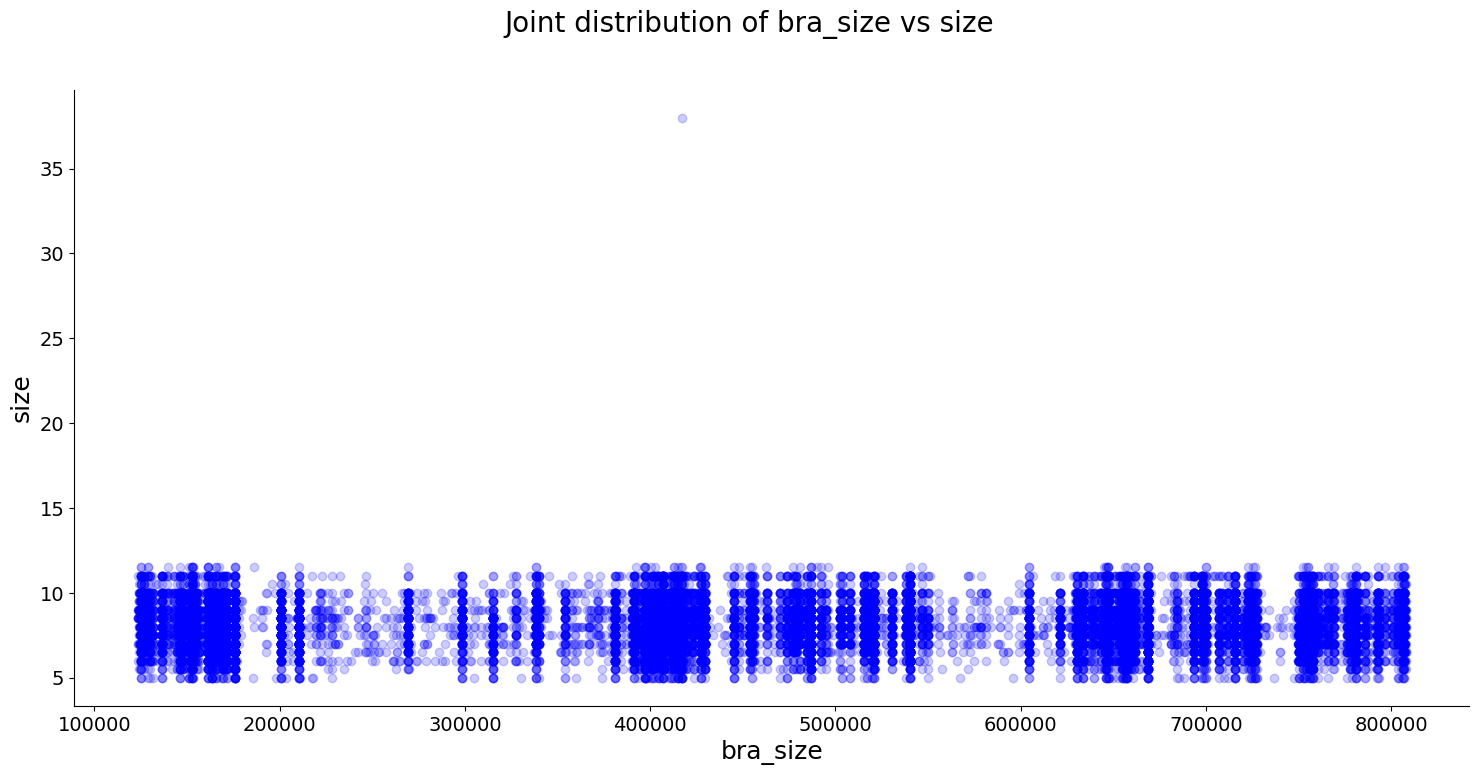

In [14]:
plt.figure(figsize=(18,8))
plt.xlabel("bra_size", fontsize=18)
plt.ylabel("size", fontsize=18)
plt.suptitle("Joint distribution of bra_size vs size", fontsize= 20)
plt.plot(mc_df.bra_size, mc_df['size'], 'bo', alpha=0.2)
plt.show()

>We can't see any significant deviation from usual behavior for bra-size, infact for all other numerical variables as well- we can expect the 'apparent' outliers, from the boxplot, to behave similarly. Now, we 'll head to preprocessing the dataset for suitable visualizations.

<a id="8"></a>
# Data Cleaning & Pre-processing
Let's handle the variables and change the dtype to the appropriate type for each column. We define a function first for creating the distribution plot of different variables. Here, is the initial distribution of features.

**Note: The final distribution plots are [below](#dist_plots).**

<a id="9"></a>
### Initial Distribution of features

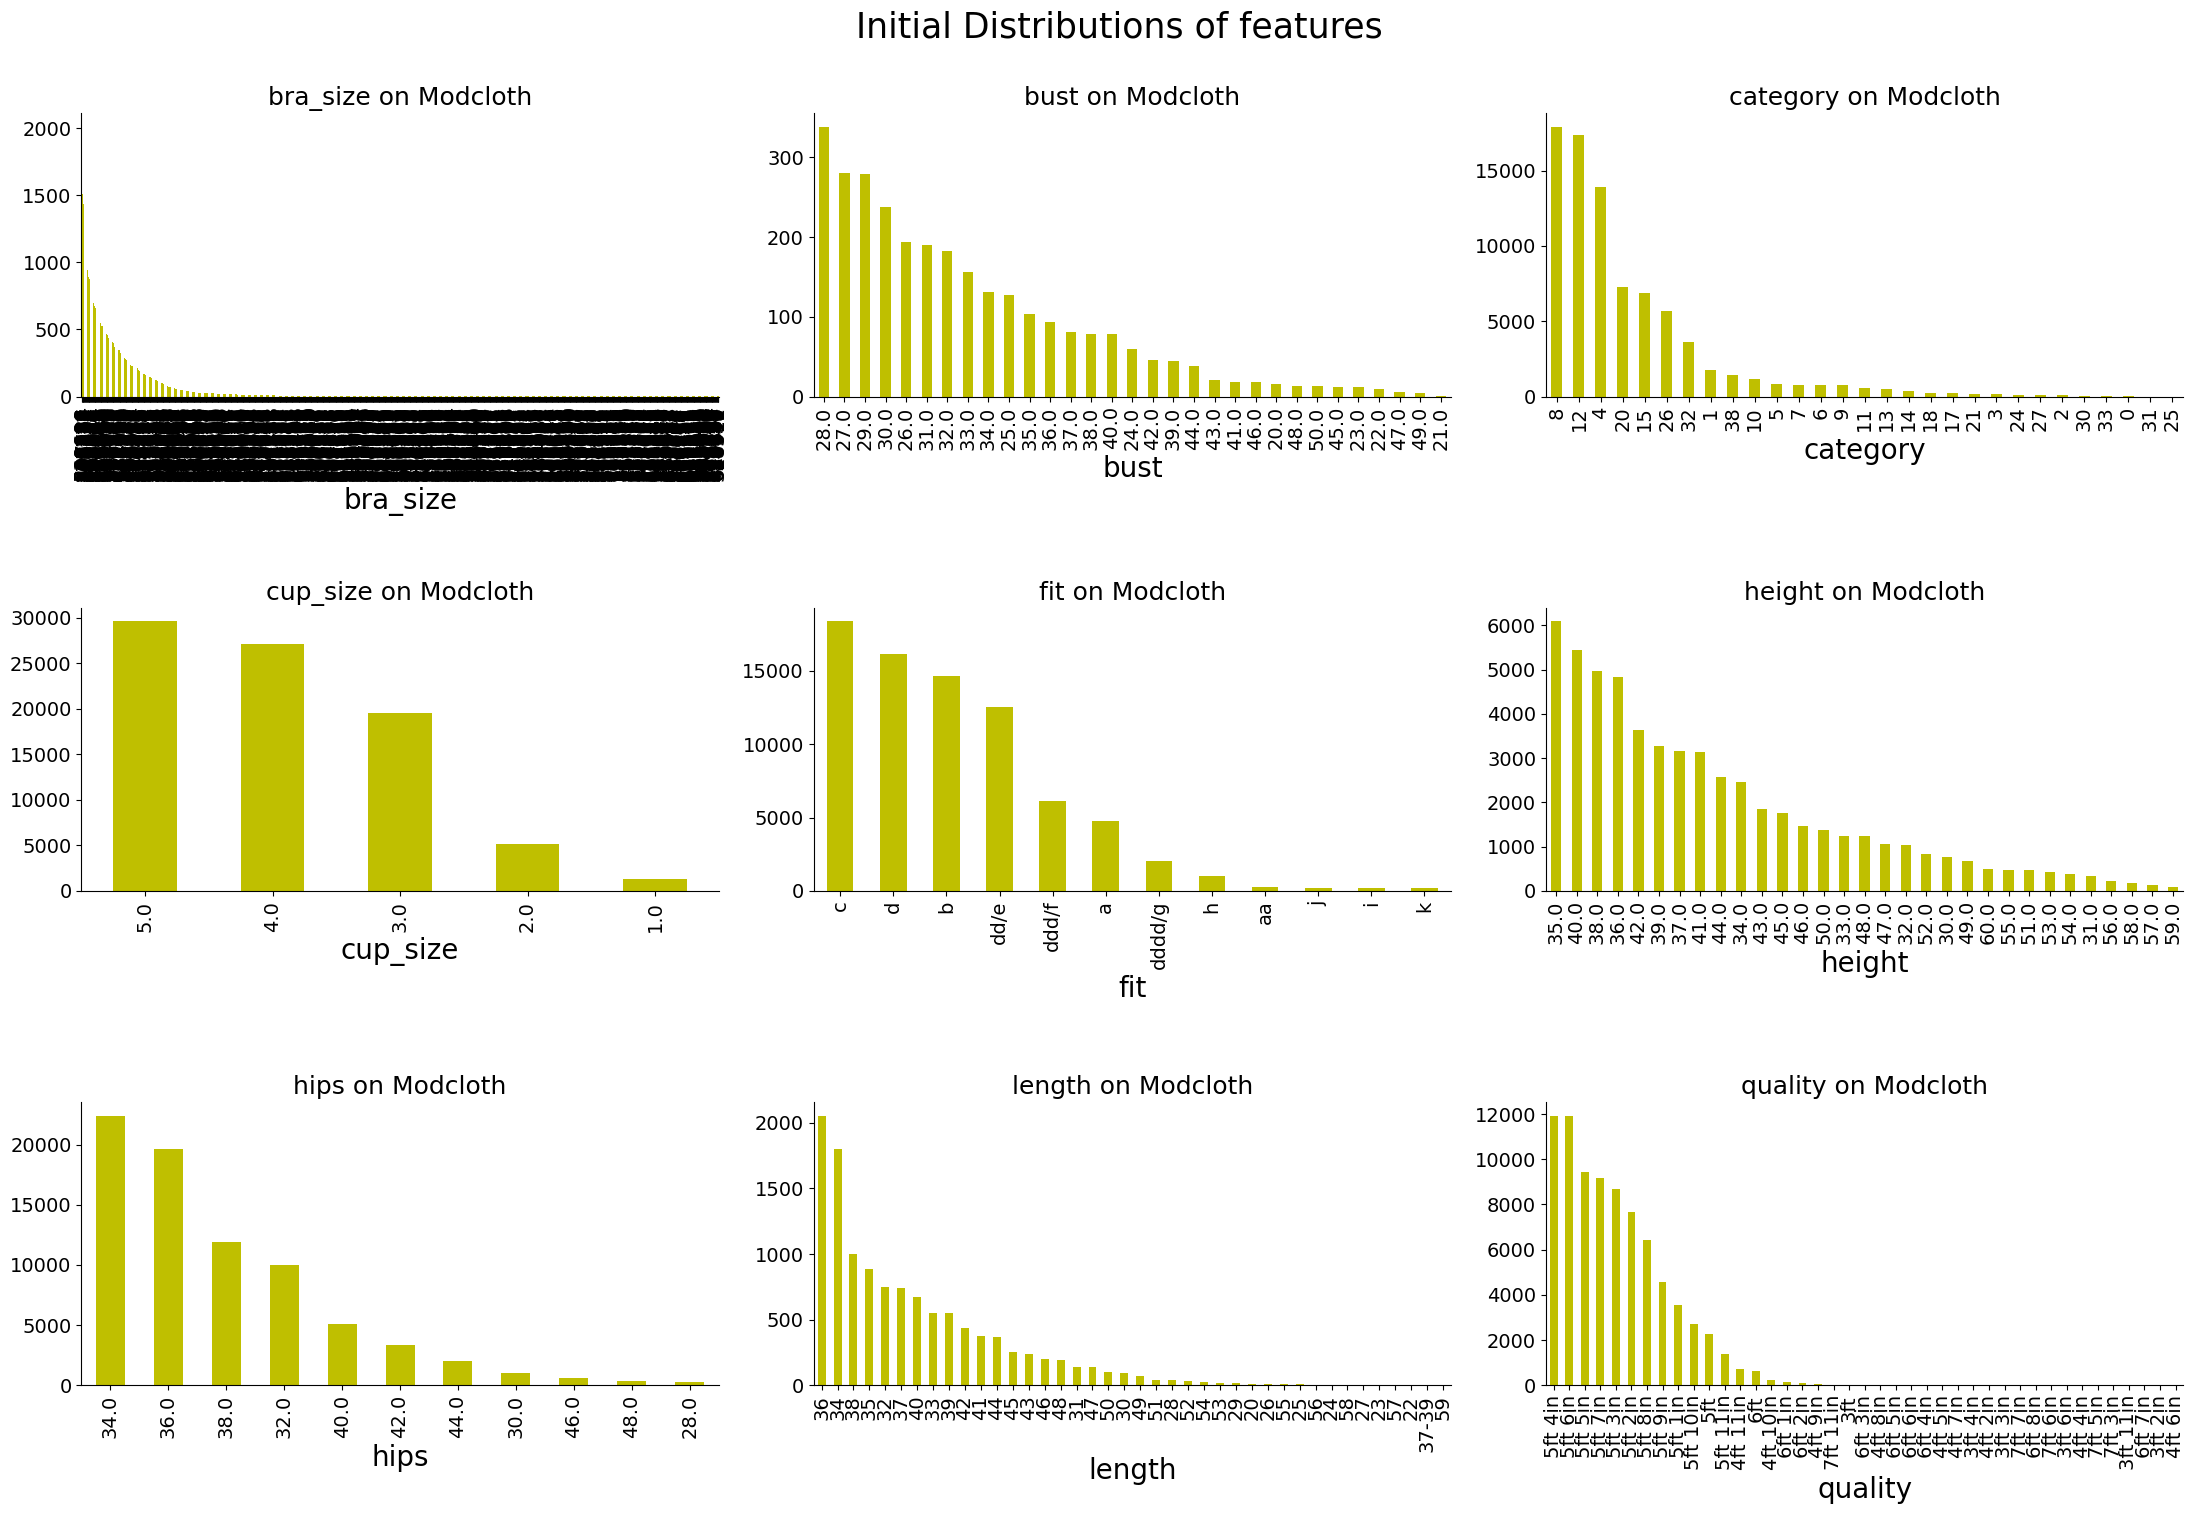

In [16]:
def plot_dist(col, ax):
    mc_df[col][mc_df[col].notnull()].value_counts().plot(kind='bar', facecolor='y', ax=ax)
    ax.set_xlabel('{}'.format(col), fontsize=20)
    ax.set_title("{} on Modcloth".format(col), fontsize= 18)
    return ax

f, ax = plt.subplots(3,3, figsize = (22,15))
f.tight_layout(h_pad=9, w_pad=2, rect=[0, 0.03, 1, 0.93])
cols = ['bra_size','bust', 'category', 'cup_size', 'fit', 'height', 'hips', 'length', 'quality']
k = 0
for i in range(3):
    for j in range(3):
        plot_dist(cols[k], ax[i][j])
        k += 1
__ = plt.suptitle("Initial Distributions of features", fontsize= 25)

<a id="10"></a>
### Step-by-step features processing:
* **bra_size:** Although it looks numerical, it only ranges from 28 to 48, with most of the sizing lying around 34-38. It makes sense to convert this to *categorical* dtype. We'll fill the NA values into an 'Unknown' category. We can see above that most of the buyers have a bra-sizing of 34 or 36.
* **bust**- We can see by looking at the values which are not null, that bust should be an integer dtype. We also need to handle a special case where bust is given as - '37-39'. We'll replace the entry of '37-39' with the mean, i.e.- 38, for analysis purposes. Now we can safely convert the dtype to int. However, considering that **roughly 86% of the bust data is missing**, eventually it was decided to remove this feature.
* **category**- none missing; change to dtype *category*.
* **cup size**- Change the dtype to *category* for this column. This col has around 7% missing values. Taking a look at the rows where this value is missing might hint us towards how to handle these missing values.

In [17]:
mc_df.bra_size = mc_df.bra_size.fillna('Unknown')
mc_df.bra_size = mc_df.bra_size.astype('category').cat.as_ordered()
mc_df.at[37313,'bust'] = '38'
mc_df.bust = mc_df.bust.fillna(0).astype(int)
mc_df.category = mc_df.category.astype('category')

In [18]:
mc_df[mc_df.cup_size.isnull()].sample(20)

,bra_size,bust,category,cup_size,fit,height,hips,item_id,length,quality,review_summary,review_text,shoe_size,shoe_width,size,user_id,user_name,waist
67252,698964,22,1,NaN,c,33.0,28.0,bottoms,32,5ft 2in,Soyoung,slightly long,fit,121128,6.0,narrow,Love this item.,I recently bought this again after I purchased...
18358,214566,24,4,NaN,b,34.0,32.0,dresses,32,5ft,Jeanne,just right,small,530179,7.5,average,adorable but runs small,"I loved this dress, but it does run small. Wo..."
73739,755526,27,4,NaN,b,39.0,34.0,bottoms,35,5ft 7in,AllieGato,just right,large,452287,8.5,NaN,"Cute skirt, but definitely size down",Just got this skirt for the second time. I fir...
23043,376359,26,8,NaN,d,38.0,32.0,sale,NaN,5ft 2in,Megan,just right,fit,603159,NaN,NaN,Don't Listen to the Other Reviews!,I listened to the other reviews that said this...
80933,801763,27,4,NaN,c,34.0,34.0,outerwear,NaN,5ft 2in,Grace,NaN,fit,500110,6.5,wide,Great workwear,This blazer adds a great professional touch to...
44937,486643,28,8,NaN,NaN,44.0,32.0,tops,37,5ft 8in,JenB,just right,small,661011,9.5,average,Tight in the bust,I purchased a Medium. The length is good. Be a...
16213,192939,37,20,NaN,c,NaN,36.0,dresses,NaN,5ft 3in,Klaoudy,slightly long,large,662270,NaN,NaN,Just did not fit,"Like everyone, when I saw this dress I wanted ..."
50202,539980,29,8,NaN,c,41.0,32.0,tops,34,5ft 10in,Maria,just right,large,627502,8.5,average,"Great cardigans, though sizing is a little inc...",I purchased several cardigans in size L at fir...
22745,358694,0,4,NaN,NaN,NaN,NaN,sale,NaN,5ft 6in,Ulysses,slightly long,large,814416,NaN,NaN,"This dress is me personified: Dark green, has ...",I bought this for the opening of an entomology...
13810,170806,0,26,NaN,h,NaN,40.0,dresses,NaN,5ft 6in,Nichole,just right,fit,496996,NaN,NaN,"Beautiful dress, but not colorfast",I bought this dress for a friends wedding. It ...


>We can't see anything glaring from the rows where this data is missing, however, as per the curator of the dataset- "***Note that these datasets are highly sparse, with most products and customers having only a single transaction.***" It does point to that maybe these customers have not bought lingerie from modcloth yet and so modcloth does not have that data. So, it makes sense to fill these null values as 'Unknown'. From the prevalence of the values like dd/e, ddd/f, and dddd/g, we can assume these to be legit cup_sizes, also confirmed by [**this**](https://www.herroom.com/full-figure-bra-cup-sizing,905,30.html) article, where some brands change the cup size dd to e, ddd to f etc. We can directly convert this to *category* dtype.

* **fit**- Change the dtype to *category* for this column. We can see that a vast majority of customers gave a good 'fit' feedback for the items on Modcloth!

In [19]:
mc_df.cup_size.fillna('Unknown', inplace=True)
mc_df.cup_size = mc_df.cup_size.astype('category').cat.as_ordered()

mc_df.fit = mc_df.fit.astype('category')

* **height**- We need to parse the height column as currently it is a string object, of the form - Xft. Yin. It will make sense to convert height to cms. We also take a look at the rows where the height data is missing.

In [20]:
def get_cms(x):
    if type(x) == type(1.0):
        return
    #print(x)
    try: 
        return (int(x[0])*30.48) + (int(x[4:-2])*2.54)
    except:
        return (int(x[0])*30.48)
mc_df.height = mc_df.height.apply(get_cms)

In [21]:
mc_df[mc_df.height.isnull()].head(20)
# Do look at the output to be able to better understand the inferences!

,bra_size,bust,category,cup_size,fit,height,hips,item_id,length,quality,review_summary,review_text,shoe_size,shoe_width,size,user_id,user_name,waist
0,123373,29,7,5.0,d,None,34.0,new,36,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN
1,123373,31,13,3.0,b,None,36.0,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN
2,123373,30,7,2.0,b,None,32.0,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.0,NaN,NaN,NaN
3,123373,0,21,5.0,dd/e,None,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN
4,123373,0,18,5.0,b,None,36.0,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN
5,123373,27,11,5.0,c,None,36.0,new,NaN,5ft 4in,Doreenajane,just right,small,162012,NaN,NaN,NaN,NaN
6,123373,26,5,1.0,b,None,32.0,new,NaN,5ft 3in,barbiejenks,just right,large,114843,NaN,NaN,NaN,NaN
7,123373,0,11,5.0,d,None,38.0,new,NaN,5ft 5in,brettloie,just right,small,58869,8.5,NaN,NaN,NaN
8,123373,0,30,4.0,d,None,42.0,new,NaN,5ft 10in,francescaviola,just right,small,279568,11.0,wide,NaN,NaN
9,123373,0,13,5.0,dd/e,None,36.0,new,39,5ft 6in,laurenpolzin,just right,fit,950172,9.0,NaN,NaN,NaN


> This filtering gives us interesting observations here:
> 1. Some customers have given bra_size, cup_size data, whereas all other measurements are empty- possible first-time purchase at Modcloth for lingerie!
> 2. Some customers have given shoe_size and all other measurements are empty- possible first-time purchase at Modcloth for shoes!
>     
> It leads us to saying that there are some first-time buyers in the dataset, also talked about by the authors of the data in [1]- about the sparsity of the data due to 1 transactions! Also, as we have no data about the height of these customers, it only makes sense to leave the missing values in the column as it is and **possibly remove these rows for future statistical modeling.** We have removed the corresponding rows.
>
>
><a id="11"></a>
> # Feature Engineering 
> ## Creating a new feature of first_time_user
> 
> Building on our observations above, it makes sense to identify the transactions which belong to first time users. We use the following logic to identify such trxns:
> * If bra_size/cup_size have a value and height, hips, shoe_size, shoe_width and waist do not- it is a first time buyer of lingerie.
> * If shoe_size/shoe_width have a value and bra_size, cup_size, height, hips, and waist do not- it is a first time buyer of shoes.
> * If hips/waist have a value and bra_size, cup_size, height, shoe_size, and shoe_width do not- it is a first time buyer of a dress/tops.
> 
> Below we will verify the above logic, with samples, before we create the new feature.
> 
> **1. Looking at the few rows where either bra_size or cup_size exists, but no other measurements are available.**
>
>**2. Looking at the few rows where either shoe_size or shoe_width exists, but no other measurements are available.**
>
>**3. Looking at the few rows where either hips or waist exists, but no other measurements are available.**

In [22]:
print(mc_df[((mc_df.bra_size != 'Unknown') | (mc_df.cup_size != 'Unknown')) & (mc_df.height.isnull()) & (mc_df.hips.isnull()) &
     (mc_df.shoe_size.isnull()) & (mc_df.shoe_width.isnull()) & (mc_df.waist.isnull())].head(3))
print(mc_df[(mc_df.bra_size == 'Unknown') & (mc_df.cup_size == 'Unknown') & (mc_df.height.isnull()) & (mc_df.hips.isnull()) &
     ((mc_df.shoe_size.notnull()) | (mc_df.shoe_width.notnull())) & (mc_df.waist.isnull())].head(3))
print(mc_df[(mc_df.bra_size == 'Unknown') & (mc_df.cup_size == 'Unknown') & (mc_df.height.isnull()) & ((mc_df.hips.notnull()) | (mc_df.waist.notnull())) &
     (mc_df.shoe_size.isnull()) & (mc_df.shoe_width.isnull())].head(3))

Empty DataFrame
Columns: [bra_size, bust, category, cup_size, fit, height, hips, item_id, length, quality, review_summary, review_text, shoe_size, shoe_width, size, user_id, user_name, waist]
Index: []
Empty DataFrame
Columns: [bra_size, bust, category, cup_size, fit, height, hips, item_id, length, quality, review_summary, review_text, shoe_size, shoe_width, size, user_id, user_name, waist]
Index: []
Empty DataFrame
Columns: [bra_size, bust, category, cup_size, fit, height, hips, item_id, length, quality, review_summary, review_text, shoe_size, shoe_width, size, user_id, user_name, waist]
Index: []


>Now we add a new column to the original data- *first_time_user*, which is a bool feature which indicates if a user, of a transaction, is a first-time user or not. This is based on the grounds that Modcloth has no previous information about the person, infact it is possible that the new user did multiple transactions in the first time!

In [23]:
lingerie_cond = (((mc_df.bra_size != 'Unknown') | (mc_df.cup_size != 'Unknown')) & (mc_df.height.isnull()) & (mc_df.hips.isnull()) &
     (mc_df.shoe_size.isnull()) & (mc_df.shoe_width.isnull()) & (mc_df.waist.isnull()))
shoe_cond = ((mc_df.bra_size == 'Unknown') & (mc_df.cup_size == 'Unknown') & (mc_df.height.isnull()) & (mc_df.hips.isnull()) &
     ((mc_df.shoe_size.notnull()) | (mc_df.shoe_width.notnull())) & (mc_df.waist.isnull()))
dress_cond = ((mc_df.bra_size == 'Unknown') & (mc_df.cup_size == 'Unknown') & (mc_df.height.isnull()) & ((mc_df.hips.notnull()) | (mc_df.waist.notnull())) &
     (mc_df.shoe_size.isnull()) & (mc_df.shoe_width.isnull()))
#print(len(mc_df[lingerie_cond]))   # To check if these items add up in the final column we are adding.
#print(len(mc_df[shoe_cond]))
#print(len(mc_df[dress_cond]))
mc_df['first_time_user'] = (lingerie_cond | shoe_cond | dress_cond)
print("Column added!")
print("Total transactions by first time users who bought bra, shoes, or a dress: " + str(sum(mc_df.first_time_user)))
print("Total first time users: " + str(len(mc_df[(lingerie_cond | shoe_cond | dress_cond)].user_id.unique())))

Column added!
Total transactions by first time users who bought bra, shoes, or a dress: 0
Total first time users: 0


* **hips**-
Hips column has a lot of missing values ~ 32.28%! We know this data would possibly be missing because Modcloth never got this data from the user most probably. We cannot remove such a significant chunk of the data, so we need another way of handling this feature. We will bin the data- on the basis of quartiles.
* **length**- There are only 35 missing rows in length, we'll take a look at these. We saw that most probably the customers did not leave behind the feedback or the data was corrupted in these rows. However, we should be able to impute these values using review related fields (if they are filled!). Or we could also simply choose to remove these rows. For the sake of this analysis, we will remove these rows.
* **quality**- There are only 68 missing rows in quality, we'll took a look at these. Similarly to length, the customers did not leave behind the feedback or the data was corrupted in these rows. We will remove these rows and convert the dtype to an ordinal variable (ordered categorical).

In [24]:
# Handling hips column
mc_df.hips = mc_df.hips.fillna(-1.0)
bins = [-5,0,31,37,40,44,75]
labels = ['Unknown','XS','S','M', 'L','XL']
mc_df.hips = pd.cut(mc_df.hips, bins, labels=labels)

# Handling length column
missing_rows = mc_df[mc_df.length.isnull()].index
mc_df.drop(missing_rows, axis = 0, inplace=True)

# Handling quality
missing_rows = mc_df[mc_df.quality.isnull()].index
mc_df.drop(missing_rows, axis = 0, inplace=True)
mc_df.quality = mc_df.quality.astype('category').cat.as_ordered()

* **review_summary/ review_text**- The NA values are there because these reviews are simply not provided by customers. Let's just fill those as 'Unknown'.
* **shoe_size** -  Roughly 66.3% of the shoe_size data is missing. We will change the shoe_size into *category* dtype and fill the NA values as 'Unknown'.
* **shoe_width** - Roughly 77.5% of the shoe_width data is missing. We will fill the NA values as 'Unknown' 
* **waist**- Waist column has the highest number of missing values - 96.5%! We will drop this column.
* **bust**- 85.6% missing values and highly correlated to bra_size. Remove.
* **user_name**- user_name itself is not needed with the user_id given. Remove.

To convert shoe_width to an ordered category type we have to import CategoricalDType and supply the order of the categories.

In [25]:
from pandas.api.types import CategoricalDtype
shoe_widths_type = CategoricalDtype(categories=['Unknown','narrow','average','wide'], ordered=True)

mc_df.review_summary = mc_df.review_summary.fillna('Unknown')
mc_df.review_text = mc_df.review_text.fillna('Unkown')
mc_df.shoe_size = mc_df.shoe_size.fillna('Unknown')
mc_df.shoe_size = mc_df.shoe_size.astype('category').cat.as_ordered()
mc_df.shoe_width = mc_df.shoe_width.fillna('Unknown')
mc_df.shoe_width = mc_df.shoe_width.astype(shoe_widths_type)
mc_df.drop(['waist', 'bust', 'user_name'], axis=1, inplace=True)
missing_rows = mc_df[mc_df.height.isnull()].index
mc_df.drop(missing_rows, axis = 0, inplace=True)

In [26]:
mc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   bra_size         0 non-null      category
 1   category         0 non-null      category
 2   cup_size         0 non-null      category
 3   fit              0 non-null      category
 4   height           0 non-null      object  
 5   hips             0 non-null      category
 6   item_id          0 non-null      object  
 7   length           0 non-null      object  
 8   quality          0 non-null      category
 9   review_summary   0 non-null      object  
 10  review_text      0 non-null      object  
 11  shoe_size        0 non-null      category
 12  shoe_width       0 non-null      category
 13  size             0 non-null      float64 
 14  user_id          0 non-null      object  
 15  first_time_user  0 non-null      bool    
dtypes: bool(1), category(8), float64(1), object(6)
memory us

We can see that now there are no more missing values! We can move onto visualizing and gaining more insight about the data.

<a id="12"></a>
# EDA via visualizations

<a id="13"></a>
<a id='dist_plots'></a>
## 1. Distribution of different features over Modcloth dataset

TypeError: no numeric data to plot

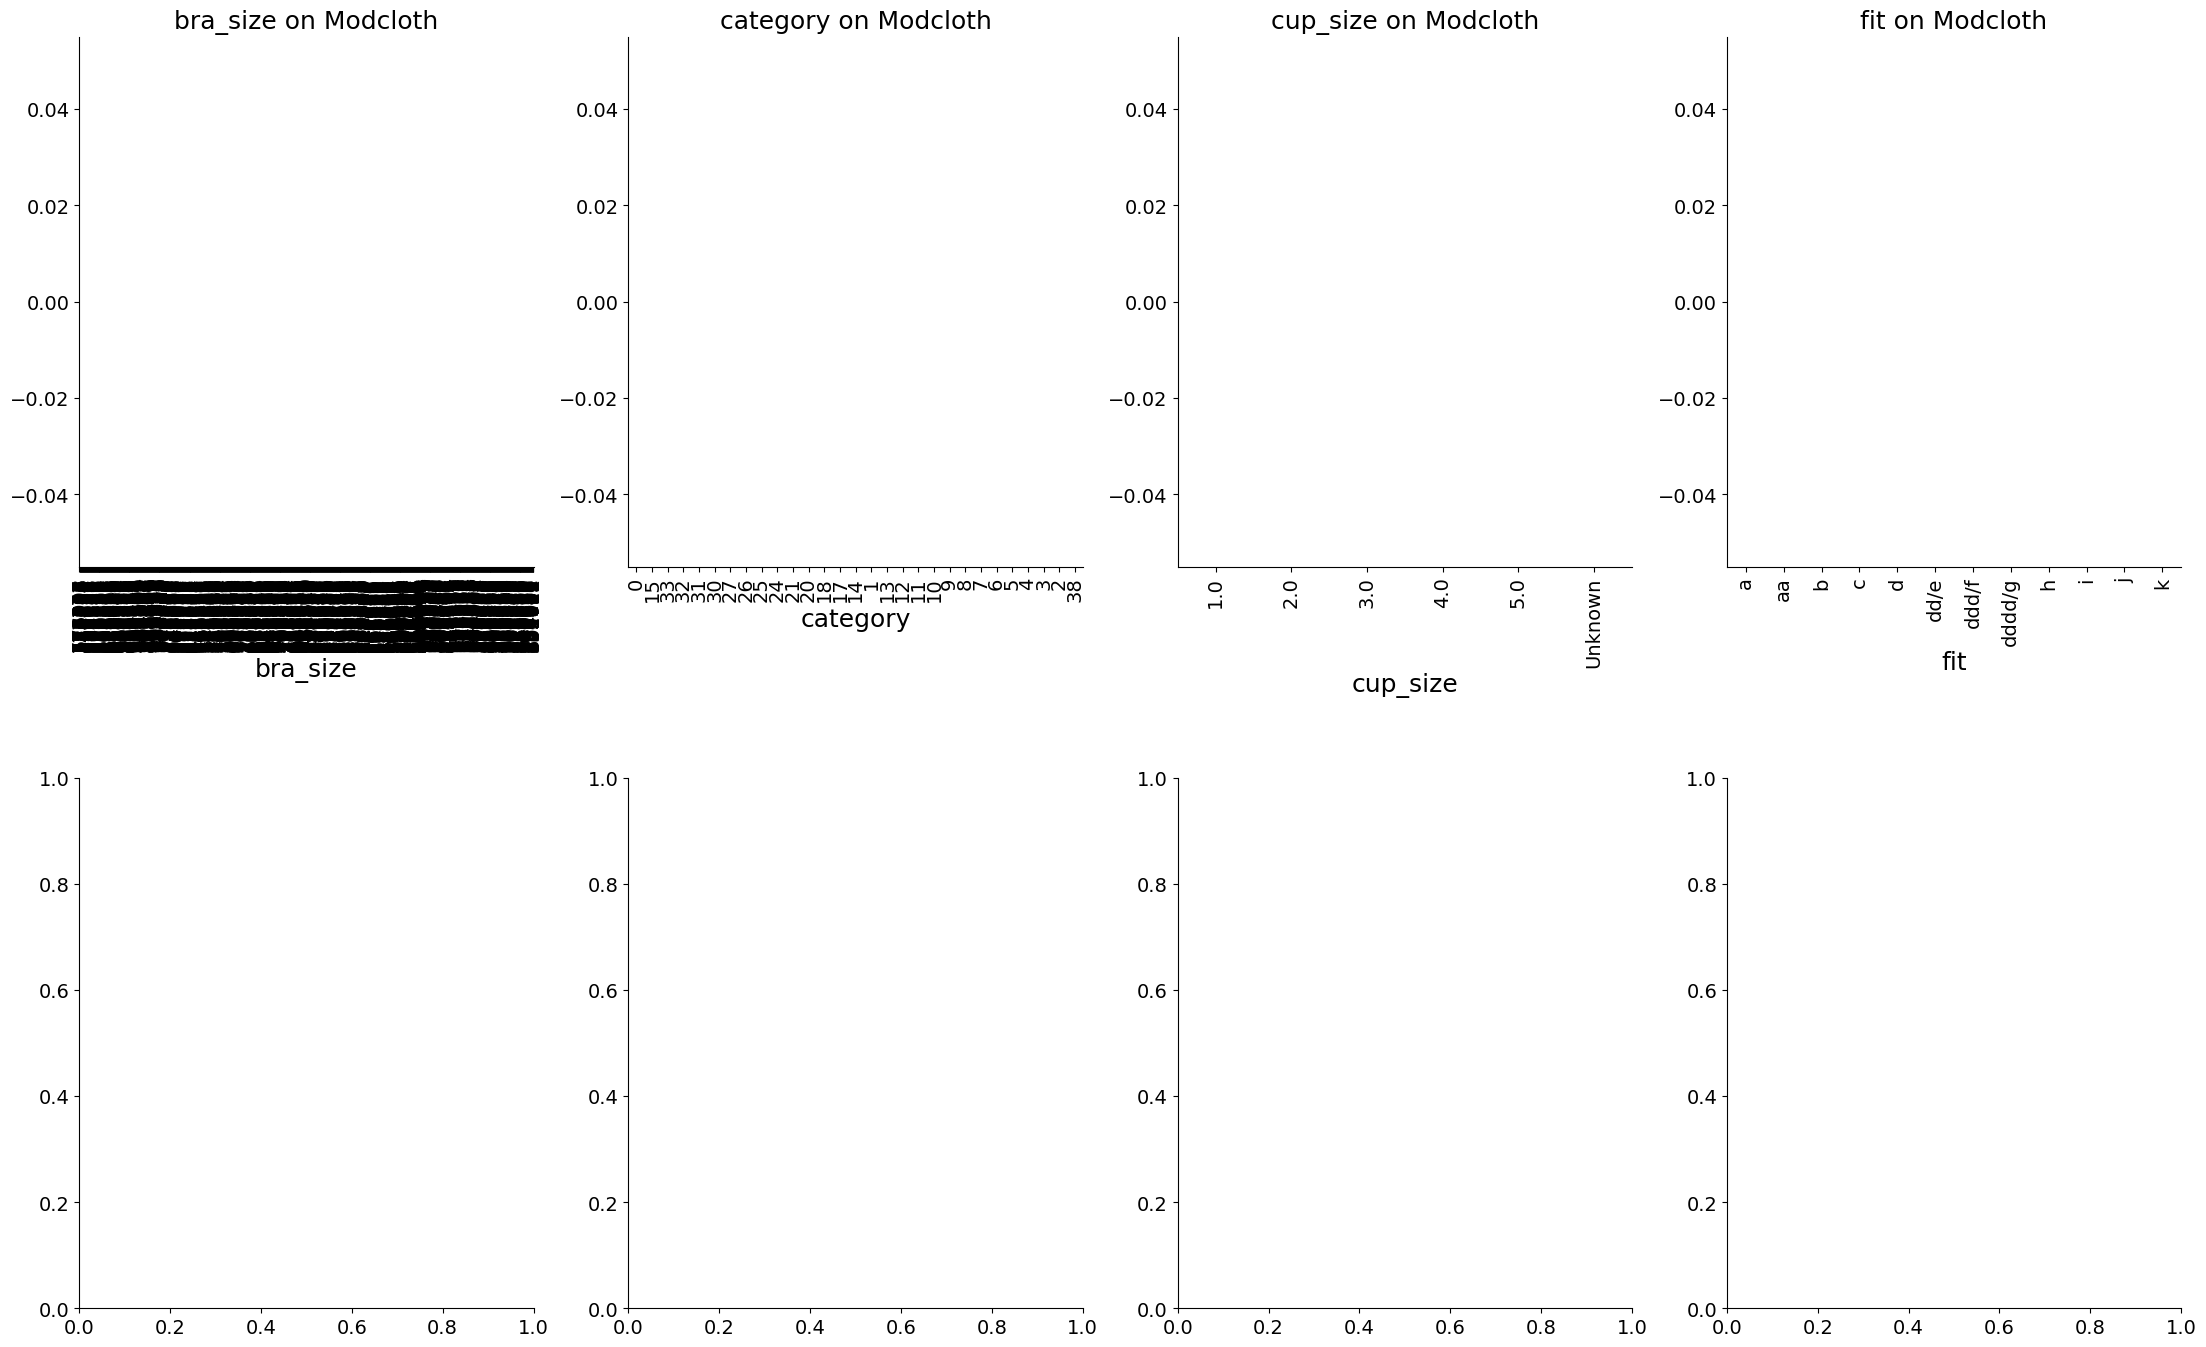

In [28]:
def plot_dist(col, ax):
    if col != 'height':
        mc_df[col].value_counts().plot(kind='bar', facecolor='y', ax=ax)
    else:
        mc_df[col].plot(kind='density', ax=ax, bw_method = 0.15, color='y')
        ax.set_xlim(130,200)
        ax.set_ylim(0, 0.07)
    ax.set_xlabel('{}'.format(col), fontsize=18)
    ax.set_title("{} on Modcloth".format(col), fontsize= 18)
    return ax

f, ax = plt.subplots(2,4, figsize = (22,15))
f.tight_layout(h_pad=9, w_pad=2, rect=[0, 0.03, 1, 0.93])
cols = ['bra_size','category', 'cup_size', 'fit', 'height', 'hips', 'length', 'quality']
k = 0
for i in range(2):
    for j in range(4):
        plot_dist(cols[k], ax[i][j])
        k += 1
__ = plt.suptitle("Final Distributions of different features", fontsize= 23)

<a id="14"></a>
## 2. Categories vs. Fit/Length/Quality
Here, we will visualize how the items of different categories fared in terms of - fit, length, and quality. This will tell Modcloth which categories need more attention! 

I have plotted 2 distributions in categories here:

**1. Unnormalized**- viewing the frequency counts directly- for comparison across categories. We also include the best fit, length, or quality measure in this plot.

**2. Normalized** -  viewing the distribution for the category after normalizing the counts, amongst the category itself- it will help us compare what are major reason for return amongst the category itself. We exclude the best sizing & quality measures, so as to focus on the pre-dominant reasons of return per category (if any).

In [29]:
def plot_barh(df,col, cmap = None, stacked=False, norm = None):
    df.plot(kind='barh', colormap=cmap, stacked=stacked)
    fig = plt.gcf()
    fig.set_size_inches(24,12)
    plt.title("Category vs {}-feedback -  Modcloth {}".format(col, '(Normalized)' if norm else ''), fontsize= 20)
    plt.ylabel('Category', fontsize = 18)
    plot = plt.xlabel('Frequency', fontsize=18)
    
def norm_counts(t):
    norms = np.linalg.norm(t.fillna(0), axis=1)
    t_norm = t[0:0]
    for row, euc in zip(t.iterrows(), norms):
        t_norm.loc[row[0]] = list(map(lambda x: x/euc, list(row[1])))
    return t_norm

In [30]:
mc_df.category.value_counts()

0     0
15    0
33    0
32    0
31    0
30    0
27    0
26    0
25    0
24    0
21    0
20    0
18    0
17    0
14    0
1     0
13    0
12    0
11    0
10    0
9     0
8     0
7     0
6     0
5     0
4     0
3     0
2     0
38    0
Name: category, dtype: int64

- **Category vs. Fit**

In [31]:
g_by_category = mc_df.groupby('category')
cat_fit = g_by_category['fit'].value_counts()
cat_fit = cat_fit.unstack()
cat_fit_norm = norm_counts(cat_fit)
cat_fit_norm.drop(['fit'], axis=1, inplace=True)
plot_barh(cat_fit, 'fit')

KeyError: "['fit'] not found in axis"

Observations:
* Best-fit response (*fit*) has been highest for *new, dresses, and tops* categories. 
* Overall maximum bad fit-feedback has belonged mostly to 2 categories- *new and tops*! *Dresses and bottoms* categories follow. 
* *Weddings, outerwear, and sale* are not prominent in our visualization- mostly due to the lack of transactions in these categories.

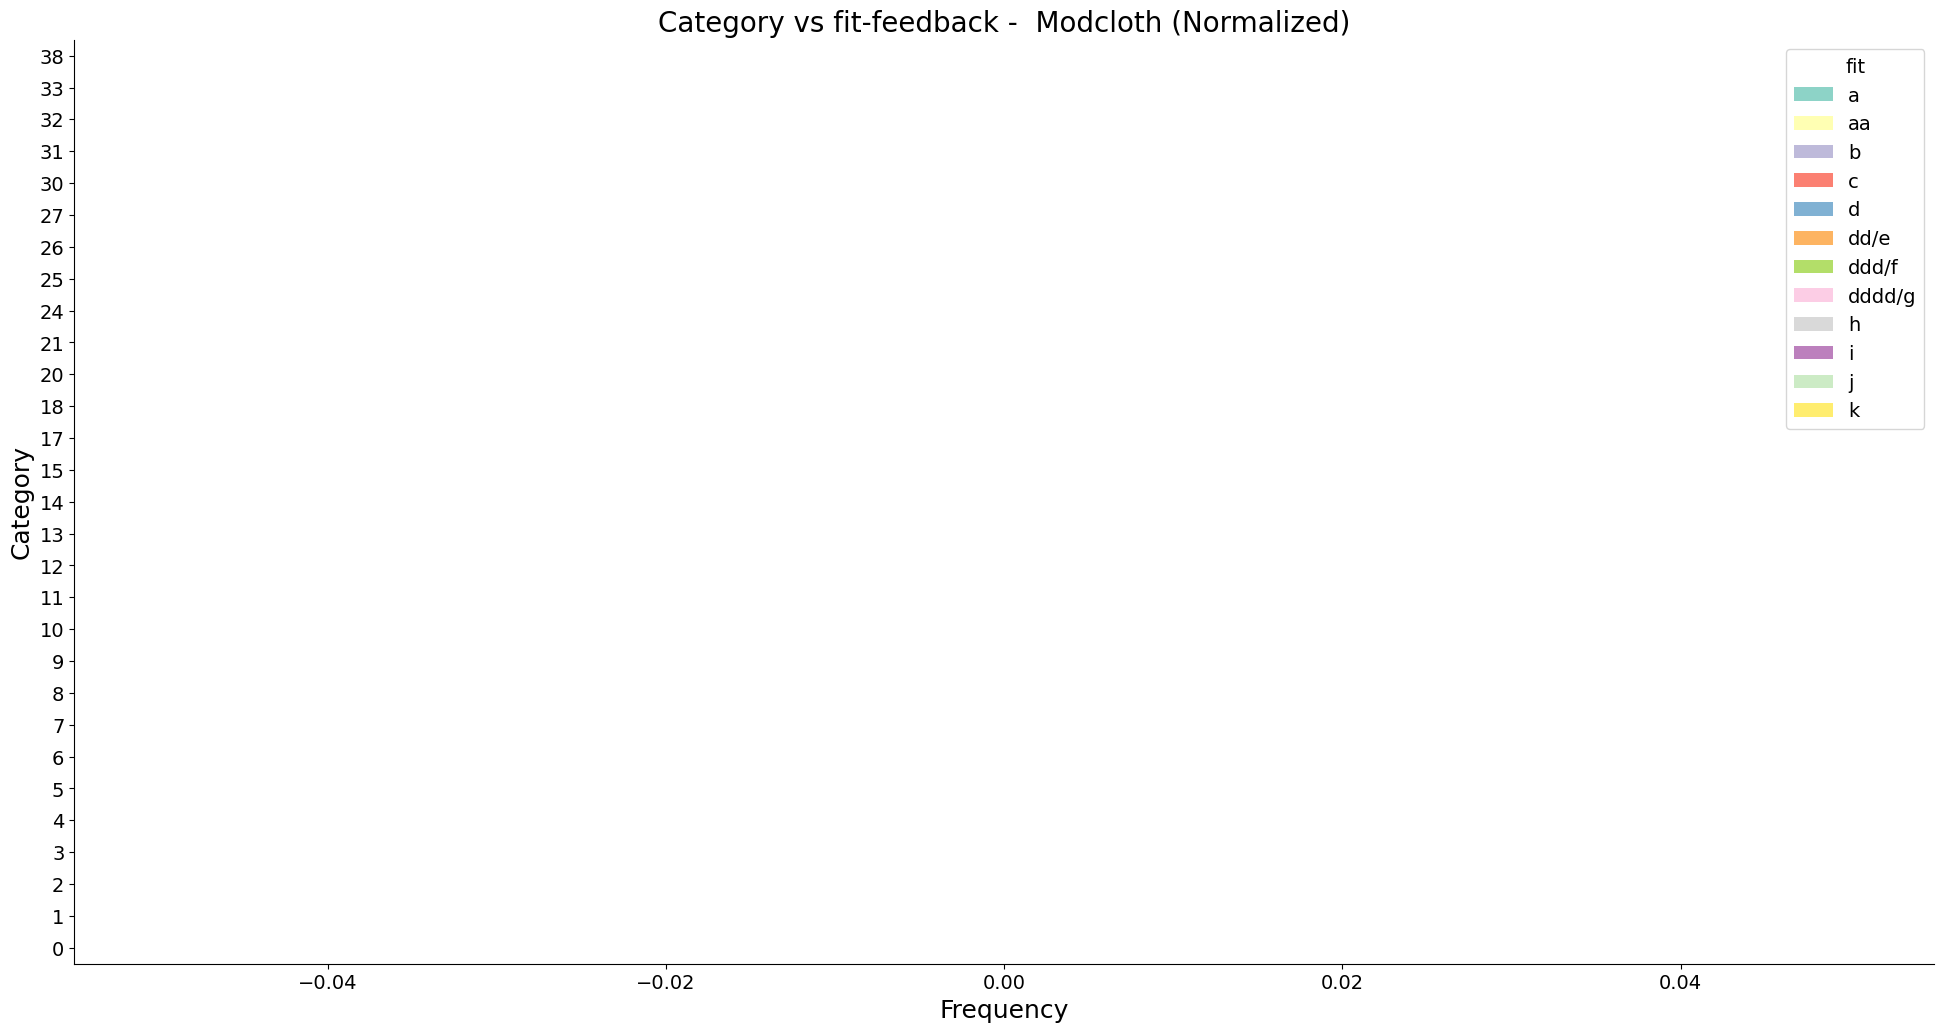

In [32]:
plot_barh(cat_fit_norm, 'fit', norm=1, cmap='Set3')

Here, we can see that amongst the categories themselves:
* Wedding, tops, & outerwear categories usually have more returns due to large sizing.
* New, sale, & bottoms usually have frequent returns due to small sized buys.
* Dresses has similar return reasons, in terms of fit.

- **Category vs Length**

In [33]:
cat_len = g_by_category['length'].value_counts()
cat_len = cat_len.unstack()
plot_barh(cat_len, 'length', 'Set3')

ValueError: operands could not be broadcast together with shape (29,) (0,)

* Best length-fitting ('just right') belongs to tops, new, dresses and bottoms! (Also due to predominance of these categories in our total transactions- **they make up almost 92% of our transactions!**)
* All transactions share a similar order of reasons for return (in the order of importance), which is kind of intuitive as well:
    * slightly long
    * slightly short
    * very long
    * very short

In [ ]:
cat_len_norm = norm_counts(cat_len)
cat_len_norm.drop(['just right'], axis = 1, inplace=True)
plot_barh(cat_len_norm, 'length', cmap='Set3', norm=1)

The normalized plot, focusing on the problems allows us to dig deeper into length-wise reasons of return per category:
* Customers tend to make 'slightly long' purchases in *bottoms, new, sale, & tops* categories.
* 'slightly short' returns take place mostly in *dresses and wedding * categories.

- **Category vs Quality**

In [ ]:
cat_quality = g_by_category['quality'].value_counts()
cat_quality = cat_quality.unstack()
plot_barh(cat_quality, 'quality', 'Set3', stacked=1)

* Almost the same share of people have rated the categories of *tops, new, dresses, & bottoms* as 5, 4, & 3.
* All the trends in terms of share of ratings seems to be constant across categories.

In [ ]:
cat_quality_norm = norm_counts(cat_quality)
cat_quality_norm.drop([5.0], axis = 1, inplace=True)
plot_barh(cat_quality_norm, 'quality', 'Set3', stacked=1, norm=1)

* Here also we can assert our previous observation that all the categories share similar share of ratings.
* To nitpick- *new , sale & tops* seem to have a higher share than normal of bad ratings (1.0 & 2.0) in terms of quality.

<a id="15"></a>
### 2. Total Number of Users vs Total Number of items bought
Visualizing the total number of users who bought *x* number of items, where we affirm the author's [[1]](#references) statement that the data is very sparse with a major chunk (38.45%) of the users who bought only 1 item from the website during the time this data was collected. 

In [ ]:
# Users who bought so many items
items_bought = []
total_users = []
for i in range(min(mc_df.user_id.value_counts()), max(mc_df.user_id.value_counts())+1):
    all_users = sum(mc_df.user_id.value_counts() == i)
    if all_users != 0:
        total_users.append(all_users)
        items_bought.append(i)
plt.xlabel("Number of items bought", fontsize = 18)
plt.ylabel("Number of users", fontsize = 18)
plt.title("Distribution of items bought by users on Modcloth")
__ = sns.barplot(x=items_bought, y=total_users, color='y')
fig = plt.gcf()
fig.set_size_inches(20,10)

* A **major chunk of the users (~40%) have only bought 1 item from Modcloth** during the time this data was collected. Although we found only 903 out of those were first time users (no previous data existed of these customers). This explains and reaffirms the dataset curator's statement about sparsity of the data.
* Most users bought 1, 2, or 3 products from Modcloth out of the ~80,000 transactions in this dataset.

<a id="16"></a>
## 3. Height vs shoe_size -  Modcloth customers
It would be interesting to see if there exists a linear relation between the height of a person and their shoe-size, i.e.- it will mean shoe-size increases with increase in height!

In [ ]:
fig = plt.gcf()
fig.set_size_inches(20,10)
__ = sns.violinplot(x='shoe_size', y='height',data=mc_df, size = 20)

We can see here a "linear correlation between foot size and height". This observation was also seen [here](https://www.statcrunch.com/5.0/viewreport.php?reportid=35115).

<a id='assumptions'></a>
# Assumptions:
The data source has been assumed as following on the Modcloth dataset: 
* item_id- from item.
* waist- from user input.
* size - from item.
* quality- from user input.
* cup size- from user input.
* hips- from user input.
* bra size- from user input.
* category- from item.
* bust- from user input.
* height- from user input
* user_name- from user input
* length - from user input
* fit- from user input
* user_id- from user.
